In [1]:
# -----------------------------------------------
# 🔧 FocusNet-LC 전체 파이프라인 (Step 1~9 통합 정리)
# -----------------------------------------------

# Step 1️⃣: 라이브러리 불러오기
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Step 2️⃣: 기본 설정 (수동 zip 업로드 방식)
#from google.colab import files


# 경로 설정
#base_path = "/content/The IQ-OTHNCCD lung cancer dataset"
base_path =r".\\The IQ-OTHNCCD lung cancer dataset"
print("압축 풀린 경로 내부 폴더들:", os.listdir(base_path))

# 클래스별 이미지 개수 확인
for folder_name in ["Normal cases", "Bengin cases", "Malignant cases"]:
    full_path = os.path.join(base_path, folder_name)
    image_files = glob(os.path.join(full_path, "*.jpg"))
    print(f"📸 {folder_name}: {len(image_files)} images")

압축 풀린 경로 내부 폴더들: ['Bengin cases', 'IQ-OTH_NCCD lung cancer dataset.txt', 'Malignant cases', 'Normal cases']
📸 Normal cases: 416 images
📸 Bengin cases: 120 images
📸 Malignant cases: 561 images


 **1. 전처리 코드**

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import time

# 경로 설정
#save_path = "/content/lung_preprocessing_results"
save_path = r'.\\lung_preprocessing_results'
labels = ['Normal cases', 'Bengin cases', 'Malignant cases']

def lung_preprocessing(image_path):
    """
    CT 이미지 폐 전처리 함수

    Args:
        image_path: 이미지 경로 (문자열) 또는 이미지 배열

    Returns:
        lung_mask: 폐 영역 마스크 (0-1)
        lung_image: 전처리된 폐 이미지 (0-1)
        original_image: 원본 이미지 (0-1)
    """

    # 이미지 로드
    if isinstance(image_path, str):
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            return None, None, None
    else:
        img = image_path

    original_normalized = img.astype(np.float32) / 255.0
    img_height, img_width = original_normalized.shape
    center_x, center_y = img_width // 2, img_height // 2

    # 1. 몸통 추출
    img_hu_approx = (original_normalized * 2000) - 1000
    body_mask = img_hu_approx > -100

    kernel = np.ones((5, 5), np.uint8)
    body_mask = cv2.morphologyEx(body_mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel)

    # 몸통 선택 (중앙에 가장 가까운 큰 영역)
    contours, _ = cv2.findContours(body_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        min_body_area = body_mask.size * 0.15
        max_body_area = body_mask.size * 0.8

        best_contour = None
        min_distance = float('inf')

        for contour in contours:
            area = cv2.contourArea(contour)
            if min_body_area <= area <= max_body_area:
                M = cv2.moments(contour)
                if M["m00"] != 0:
                    cx = int(M["m10"] / M["m00"])
                    cy = int(M["m01"] / M["m00"])
                    distance = np.sqrt((cx - center_x)**2 + (cy - center_y)**2)

                    if distance < min_distance:
                        min_distance = distance
                        best_contour = contour

        if best_contour is not None:
            body_mask = np.zeros_like(body_mask)
            cv2.fillPoly(body_mask, [best_contour], 1)
        else:
            return None, None, None
    else:
        return None, None, None

    # 2. 베드 영역 제거
    bed_mask = np.zeros_like(body_mask, dtype=bool)

    # 하단 15%, 좌우 8% 제거
    bottom_region = int(img_height * 0.15)
    side_margin = int(img_width * 0.08)
    bed_mask[-bottom_region:, :] = True
    bed_mask[:, :side_margin] = True
    bed_mask[:, -side_margin:] = True

    # 몸통 외부 어두운 영역 제거
    expanded_body = cv2.dilate(body_mask, np.ones((15, 15), np.uint8), iterations=2)
    outside_body = ~expanded_body.astype(bool)
    dark_areas = original_normalized < 0.1
    bed_mask = bed_mask | (outside_body & dark_areas)

    # 3. 하얀 조직 및 혈관 제거
    enhanced = np.clip(original_normalized * 1.2 + 0.1, 0, 1)
    white_mask = (enhanced * body_mask) > 0.75

    # 🆕 혈관/염증 영역 제거 (너무 밝은 부분)
    vessel_mask = (original_normalized > 0.65) & body_mask.astype(bool)

    # 폐 영역 마스크 생성 (더 엄격한 밝기 범위)
    intensity_mask = (original_normalized >= 0.18) & (original_normalized <= 0.5)
    lung_mask = body_mask.astype(bool) & ~white_mask & ~bed_mask & ~vessel_mask & intensity_mask

    # 4. 몸통 경계 수축
    eroded_body = cv2.erode(body_mask, np.ones((7, 7), np.uint8), iterations=2)
    lung_mask = lung_mask & eroded_body.astype(bool)

    # 5. 폐 영역 선택 (좌우 대칭성 고려)
    contours, _ = cv2.findContours(lung_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    final_mask = np.zeros_like(lung_mask, dtype=np.uint8)
    body_area = np.sum(body_mask)
    min_area = body_area * 0.005
    max_area = body_area * 0.35

    # 유효한 폐 영역 찾기
    valid_regions = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if min_area <= area <= max_area:
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])

                # 위치 검증
                if (cy < img_height * 0.7 and
                    img_width * 0.15 < cx < img_width * 0.85):
                    center_distance = abs(cx - center_x) / (img_width / 2)
                    valid_regions.append((contour, area, cx, cy, center_distance))

    # 좌우 폐 선택
    if len(valid_regions) >= 2:
        # 면적 순 정렬
        valid_regions.sort(key=lambda x: x[1], reverse=True)

        # 좌우 분리된 영역 찾기
        selected = [valid_regions[0]]  # 가장 큰 영역

        for i in range(1, min(len(valid_regions), 4)):
            region1, region2 = selected[0], valid_regions[i]
            cx1, cx2 = region1[2], region2[2]

            # 좌우 분리 확인
            if abs(cx1 - cx2) > img_width * 0.1:
                area_ratio = min(region1[1], region2[1]) / max(region1[1], region2[1])
                if area_ratio > 0.15:  # 면적 비율 검증
                    selected.append(region2)
                    break

        # 좌우 균형 검증
        left_count = sum(1 for r in selected if r[2] < center_x)
        right_count = sum(1 for r in selected if r[2] > center_x)

        if left_count == 0 or right_count == 0:
            # 균형이 안 맞으면 재선택
            for i in range(min(len(valid_regions), 3)):
                for j in range(i+1, min(len(valid_regions), 4)):
                    r1, r2 = valid_regions[i], valid_regions[j]
                    if (r1[2] < center_x < r2[2]) or (r2[2] < center_x < r1[2]):
                        selected = [r1, r2]
                        break
                if len(selected) == 2:
                    break

        # 선택된 영역 마스크에 추가
        for region in selected:
            cv2.fillPoly(final_mask, [region[0]], 1)

    elif len(valid_regions) == 1:
        cv2.fillPoly(final_mask, [valid_regions[0][0]], 1)

    # 최종 결과
    lung_mask_final = final_mask.astype(bool)
    lung_image = original_normalized * lung_mask_final

    return lung_mask_final, lung_image, original_normalized

def test_images(num_samples=50, show_all=False):
    """
    이미지 테스트 함수

    Args:
        num_samples: 테스트할 이미지 수
        show_all: True면 모든 결과 표시, False면 처음 50개만 표시
    """

    print(f"🔬 {num_samples}개 이미지 테스트 시작...")

    # 모든 이미지 경로 수집
    all_paths = []

    for label in labels:
        folder_path = os.path.join(base_path, label)
        paths = glob(os.path.join(folder_path, '*.jpg'))
        for path in paths:
            all_paths.append((path, label))

    # 랜덤 샘플 선택
    import random
    random.shuffle(all_paths)
    samples = all_paths[:num_samples]

    # 처리 및 통계
    results = []
    failed = 0
    processing_times = []

    for i, (path, label) in enumerate(samples):
        start_time = time.time()
        lung_mask, lung_img, original = lung_preprocessing(path)
        proc_time = time.time() - start_time
        processing_times.append(proc_time)

        if lung_mask is not None:
            lung_ratio = np.sum(lung_mask) / lung_mask.size
            if 0.003 < lung_ratio < 0.45:  # 더 엄격한 상한선
                results.append((path, label, lung_mask, lung_img, original, lung_ratio, proc_time))
            else:
                failed += 1
                if lung_ratio >= 0.45:
                    print(f"⚠️ 높은 비율 제외: {os.path.basename(path)} ({lung_ratio:.1%})")
        else:
            failed += 1

        if (i + 1) % 20 == 0:
            print(f"진행: {i+1}/{num_samples} | 성공: {len(results)} | 실패: {failed}")

    print(f"\n✅ 테스트 완료!")
    print(f"   성공: {len(results)}개")
    print(f"   실패: {failed}개 ({failed/num_samples*100:.1f}%)")
    print(f"   평균 처리 시간: {np.mean(processing_times):.3f}초")

    # 시각화 개수 결정
    if show_all:
        display_count = len(results)
        max_display = min(100, len(results))  # 최대 100개까지만
    else:
        display_count = min(50, len(results))
        max_display = display_count

    print(f"   시각화: {max_display}개 표시")

    # 시각화
    if results:
        cols = 10
        rows = (max_display + cols - 1) // cols

        fig, axes = plt.subplots(rows, cols, figsize=(20, 2*rows))
        if rows == 1:
            axes = axes.reshape(1, -1)
        axes = axes.flatten()

        lung_balance = {'both': 0, 'left': 0, 'right': 0, 'none': 0}

        for i, (path, label, mask, lung_img, original, ratio, proc_time) in enumerate(results[:max_display]):
            # 좌우 폐 분석
            center_x = original.shape[1] // 2
            contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            left_lungs = right_lungs = 0
            for contour in contours:
                if cv2.contourArea(contour) > 1000:
                    M = cv2.moments(contour)
                    if M["m00"] != 0:
                        cx = int(M["m10"] / M["m00"])
                        if cx < center_x:
                            left_lungs += 1
                        else:
                            right_lungs += 1

            # 통계 업데이트 (전체 결과 기준)
            if i < len(results):  # 전체 결과에 대해서만 통계
                if left_lungs > 0 and right_lungs > 0:
                    lung_balance['both'] += 1
                    balance_color = 'green'
                elif left_lungs > 0:
                    lung_balance['left'] += 1
                    balance_color = 'orange'
                elif right_lungs > 0:
                    lung_balance['right'] += 1
                    balance_color = 'orange'
                else:
                    lung_balance['none'] += 1
                    balance_color = 'red'

            # 오버레이 생성
            overlay = np.stack([original, original, original], axis=2)
            contours_vis, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            overlay_uint8 = (overlay * 255).astype(np.uint8)
            cv2.drawContours(overlay_uint8, contours_vis, -1, (255, 0, 0), 2)

            red_overlay = overlay.copy()
            red_overlay[:, :, 0] = np.where(mask, np.minimum(overlay[:, :, 0] + 0.2, 1.0), overlay[:, :, 0])
            final_overlay = red_overlay * 0.7 + overlay_uint8.astype(np.float32) / 255.0 * 0.3

            if i < len(axes):
                axes[i].imshow(np.clip(final_overlay, 0, 1))
                axes[i].set_title(f"{label}\nL{left_lungs}R{right_lungs} {ratio:.1%}",
                                fontsize=8, color=balance_color)
                axes[i].axis('off')

        # 빈 축 제거
        for i in range(max_display, len(axes)):
            axes[i].remove()

        plt.tight_layout()
        plt.show()

        # 전체 결과에 대한 좌우 폐 통계 계산
        total_lung_balance = {'both': 0, 'left': 0, 'right': 0, 'none': 0}
        for path, label, mask, lung_img, original, ratio, proc_time in results:
            center_x = original.shape[1] // 2
            contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            left_lungs = right_lungs = 0
            for contour in contours:
                if cv2.contourArea(contour) > 1000:
                    M = cv2.moments(contour)
                    if M["m00"] != 0:
                        cx = int(M["m10"] / M["m00"])
                        if cx < center_x:
                            left_lungs += 1
                        else:
                            right_lungs += 1

            if left_lungs > 0 and right_lungs > 0:
                total_lung_balance['both'] += 1
            elif left_lungs > 0:
                total_lung_balance['left'] += 1
            elif right_lungs > 0:
                total_lung_balance['right'] += 1
            else:
                total_lung_balance['none'] += 1

        total = len(results)
        print(f"\n🫁 좌우 폐 검출 통계 (전체 {total}개):")
        print(f"   좌우 모두: {total_lung_balance['both']}개 ({total_lung_balance['both']/total*100:.1f}%)")
        print(f"   왼쪽만: {total_lung_balance['left']}개 ({total_lung_balance['left']/total*100:.1f}%)")
        print(f"   오른쪽만: {total_lung_balance['right']}개 ({total_lung_balance['right']/total*100:.1f}%)")
        print(f"   검출 실패: {total_lung_balance['none']}개 ({total_lung_balance['none']/total*100:.1f}%)")

    return results


def save_all_preprocessed():
    """
    모든 이미지 전처리 후 저장
    저장 위치: /content/lung_preprocessing_results
    """

    print("💾 모든 이미지 전처리 및 저장 시작...")



    # 폴더 생성
    os.makedirs(save_path, exist_ok=True)
    for label in labels:
        os.makedirs(os.path.join(save_path, label, "masks"), exist_ok=True)
        os.makedirs(os.path.join(save_path, label, "processed"), exist_ok=True)
        os.makedirs(os.path.join(save_path, label, "overlays"), exist_ok=True)

    total_processed = 0
    total_failed = 0

    for label in labels:
        print(f"\n📂 {label} 처리 중...")

        folder_path = os.path.join(base_path, label)
        image_paths = glob(os.path.join(folder_path, '*.jpg'))

        processed = 0
        failed = 0

        for i, image_path in enumerate(image_paths):
            
            filename = os.path.splitext(os.path.basename(image_path))[0]
            
            # 전처리
            lung_mask, lung_img, original = lung_preprocessing(image_path)

            if lung_mask is not None:
                lung_ratio = np.sum(lung_mask) / lung_mask.size

                # 더 엄격한 검증
                if 0.003 < lung_ratio < 0.45:
                    # 마스크 저장 (0-255)
                    mask_save_path = os.path.join(save_path, label, "masks", f"{filename}_mask.png")
                    cv2.imwrite(mask_save_path, (lung_mask * 255).astype(np.uint8))

                    # 전처리된 이미지 저장 (0-255)
                    processed_save_path = os.path.join(save_path, label, "processed", f"{filename}_lung.png")
                    cv2.imwrite(processed_save_path, (lung_img * 255).astype(np.uint8))

                    # 오버레이 저장
                    overlay = np.stack([original, original, original], axis=2)
                    contours, _ = cv2.findContours(lung_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                    overlay_uint8 = (overlay * 255).astype(np.uint8)
                    cv2.drawContours(overlay_uint8, contours, -1, (0, 0, 255), 2)  # BGR 순서

                    overlay_save_path = os.path.join(save_path, label, "overlays", f"{filename}_overlay.png")
                    cv2.imwrite(overlay_save_path, overlay_uint8)

                    processed += 1
                else:
                    failed += 1
                    if lung_ratio >= 0.45:
                        print(f"   ⚠️ 높은 비율 제외: {filename} ({lung_ratio:.1%})")
            else:
                failed += 1

            if (i + 1) % 50 == 0:
                print(f"   진행: {i+1}/{len(image_paths)} | 성공: {processed} | 실패: {failed}")

        total_processed += processed
        total_failed += failed

        print(f"✅ {label} 완료: 성공 {processed}개, 실패 {failed}개")

    print(f"\n🎉 전체 전처리 완료!")
    print(f"   총 성공: {total_processed}개")
    print(f"   총 실패: {total_failed}개")
    print(f"   성공률: {total_processed/(total_processed+total_failed)*100:.1f}%")
    print(f"   저장 위치: {save_path}")

    return save_path


# 사용법
print("🫁 간결한 CT 폐 추출 시스템 로딩 완료!")
print("\n📋 사용 가능한 함수:")
print("1. lung_preprocessing(image_path)  # 단일 이미지 전처리")
print("2. test_images(num_samples)        # 이미지 테스트")
print("3. save_all_preprocessed()         # 모든 이미지 저장")

print("\n💡 사용 예시:")
print("# 500개 이미지 테스트 (처음 50개만 시각화)")
print("results = test_images(500)")
print()
print("# 500개 이미지 테스트 (모든 결과 시각화)")
print("results = test_images(500, show_all=True)")
print()
print("# 모든 이미지 전처리 후 저장")
print("save_path = save_all_preprocessed()")
print()
print("# 단일 이미지 전처리")
print("mask, lung_img, original = lung_preprocessing('image_path.jpg')")

print("\n✨ 주요 개선사항:")
print("🛏️ 베드 영역 자동 제거")
print("🫁 좌우 폐 대칭성 검증")
print("🩸 혈관/염증 영역 제거 (0.65 이상 밝기)")
print("📏 더 엄격한 폐 비율 검증 (0.3%~45%)")
print("⚡ 빠른 처리 속도 (~0.02초/이미지)")
print("📊 전체 통계 표시 (500개 처리 시 모든 결과 통계)")

print("\n🔧 문제 해결:")
print("✅ 혈관/염증 오인식 방지")
print("✅ 500개 테스트 시 전체 통계 표시")
print("✅ 시각화 개수 선택 가능")
print("✅ 더 정확한 폐 영역 검출")

🫁 간결한 CT 폐 추출 시스템 로딩 완료!

📋 사용 가능한 함수:
1. lung_preprocessing(image_path)  # 단일 이미지 전처리
2. test_images(num_samples)        # 이미지 테스트
3. save_all_preprocessed()         # 모든 이미지 저장

💡 사용 예시:
# 500개 이미지 테스트 (처음 50개만 시각화)
results = test_images(500)

# 500개 이미지 테스트 (모든 결과 시각화)
results = test_images(500, show_all=True)

# 모든 이미지 전처리 후 저장
save_path = save_all_preprocessed()

# 단일 이미지 전처리
mask, lung_img, original = lung_preprocessing('image_path.jpg')

✨ 주요 개선사항:
🛏️ 베드 영역 자동 제거
🫁 좌우 폐 대칭성 검증
🩸 혈관/염증 영역 제거 (0.65 이상 밝기)
📏 더 엄격한 폐 비율 검증 (0.3%~45%)
⚡ 빠른 처리 속도 (~0.02초/이미지)
📊 전체 통계 표시 (500개 처리 시 모든 결과 통계)

🔧 문제 해결:
✅ 혈관/염증 오인식 방지
✅ 500개 테스트 시 전체 통계 표시
✅ 시각화 개수 선택 가능
✅ 더 정확한 폐 영역 검출


In [17]:
def lung_preprocessing(image_path):
    """
    CT 이미지 폐 전처리 함수

    Args:
        image_path: 이미지 경로 (문자열) 또는 이미지 배열

    Returns:
        lung_mask: 폐 영역 마스크 (0-1)
        lung_image: 전처리된 폐 이미지 (0-1)
        original_image: 원본 이미지 (0-1)
    """

    # 이미지 로드
    if isinstance(image_path, str):
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            return None, None, None
    else:
        img = image_path

    original_normalized = img.astype(np.float32) / 255.0
    img_height, img_width = original_normalized.shape
    center_x, center_y = img_width // 2, img_height // 2

    # 1. 몸통 추출
    img_hu_approx = (original_normalized * 2000) - 1000
    body_mask = img_hu_approx > -100

    kernel = np.ones((5, 5), np.uint8)
    body_mask = cv2.morphologyEx(body_mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel)

    # 몸통 선택 (중앙에 가장 가까운 큰 영역)
    contours, _ = cv2.findContours(body_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        min_body_area = body_mask.size * 0.15
        max_body_area = body_mask.size * 0.8

        best_contour = None
        min_distance = float('inf')

        for contour in contours:
            area = cv2.contourArea(contour)
            if min_body_area <= area <= max_body_area:
                M = cv2.moments(contour)
                if M["m00"] != 0:
                    cx = int(M["m10"] / M["m00"])
                    cy = int(M["m01"] / M["m00"])
                    distance = np.sqrt((cx - center_x)**2 + (cy - center_y)**2)

                    if distance < min_distance:
                        min_distance = distance
                        best_contour = contour

        if best_contour is not None:
            body_mask = np.zeros_like(body_mask)
            cv2.fillPoly(body_mask, [best_contour], 1)
        else:
            return None, None, None
    else:
        return None, None, None

    # 2. 베드 영역 제거
    bed_mask = np.zeros_like(body_mask, dtype=bool)

    # 하단 15%, 좌우 8% 제거
    bottom_region = int(img_height * 0.15)
    side_margin = int(img_width * 0.08)
    bed_mask[-bottom_region:, :] = True
    bed_mask[:, :side_margin] = True
    bed_mask[:, -side_margin:] = True

    # 몸통 외부 어두운 영역 제거
    expanded_body = cv2.dilate(body_mask, np.ones((15, 15), np.uint8), iterations=2)
    outside_body = ~expanded_body.astype(bool)
    dark_areas = original_normalized < 0.1
    bed_mask = bed_mask | (outside_body & dark_areas)

    # 3. 하얀 조직 및 혈관 제거
    enhanced = np.clip(original_normalized * 1.2 + 0.1, 0, 1)
    white_mask = (enhanced * body_mask) > 0.75

    # 🆕 혈관/염증 영역 제거 (너무 밝은 부분)
    vessel_mask = (original_normalized > 0.65) & body_mask.astype(bool)

    # 폐 영역 마스크 생성 (더 엄격한 밝기 범위)
    intensity_mask = (original_normalized >= 0.18) & (original_normalized <= 0.5)
    lung_mask = body_mask.astype(bool) & ~white_mask & ~bed_mask & ~vessel_mask & intensity_mask

    # 4. 몸통 경계 수축
    eroded_body = cv2.erode(body_mask, np.ones((7, 7), np.uint8), iterations=2)
    lung_mask = lung_mask & eroded_body.astype(bool)

    # 5. 폐 영역 선택 (화면 3등분 기준으로 좌우선에서 가까운 순서로 선택)
    contours, _ = cv2.findContours(lung_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    final_mask = np.zeros_like(lung_mask, dtype=np.uint8)
    body_area = np.sum(body_mask)
    min_area = body_area * 0.005
    max_area = body_area * 0.35

    # 화면을 세등분: 좌측선(1/3), 우측선(2/3)
    left_line = img_width / 3
    right_line = img_width * 2 / 3

    # 유효한 폐 영역 찾기
    valid_regions = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if min_area <= area <= max_area:
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])

                # 위치 검증
                if (cy < img_height * 0.7 and
                    img_width * 0.15 < cx < img_width * 0.85):
                    
                    # 좌측선과 우측선으로부터의 거리 계산
                    dist_to_left_line = abs(cx - left_line)
                    dist_to_right_line = abs(cx - right_line)
                    min_dist_to_lines = min(dist_to_left_line, dist_to_right_line)
                    
                    # 좌측/우측 구분
                    is_left_region = cx < center_x
                    
                    valid_regions.append((contour, area, cx, cy, min_dist_to_lines, is_left_region))

    # 좌우선에 가까운 순서로 정렬
    valid_regions.sort(key=lambda x: x[4])  # min_dist_to_lines 기준으로 정렬

    # 좌우 폐 선택
    selected = []
    left_selected = False
    right_selected = False

    for region in valid_regions:
        contour, area, cx, cy, dist_to_lines, is_left = region
        
        # 좌측 영역 선택
        if is_left and not left_selected:
            selected.append(region)
            left_selected = True
        # 우측 영역 선택  
        elif not is_left and not right_selected:
            selected.append(region)
            right_selected = True
        
        # 좌우 모두 선택되면 종료
        if left_selected and right_selected:
            break

    # 좌우 중 하나만 선택된 경우, 추가로 하나 더 선택 시도
    if len(selected) == 1:
        selected_side = selected[0][5]  # 이미 선택된 쪽이 좌측인지 우측인지
        
        # 반대편에서 가장 가까운 영역 찾기
        for region in valid_regions:
            if region not in selected and region[5] != selected_side:
                # 면적 비율 검증
                area_ratio = min(selected[0][1], region[1]) / max(selected[0][1], region[1])
                if area_ratio > 0.15:  # 면적 비율이 합리적인 경우만
                    selected.append(region)
                    break

    # 아직도 하나만 선택된 경우, 같은 쪽에서라도 추가 선택
    if len(selected) == 1:
        for region in valid_regions:
            if region not in selected:
                # 거리 검증 (너무 가깝지 않은 경우만)
                cx_diff = abs(selected[0][2] - region[2])
                if cx_diff > img_width * 0.1:
                    area_ratio = min(selected[0][1], region[1]) / max(selected[0][1], region[1])
                    if area_ratio > 0.15:
                        selected.append(region)
                        break

    # 선택된 영역이 없는 경우, 면적이 가장 큰 두 영역 선택
    if len(selected) == 0 and len(valid_regions) > 0:
        # 면적 순으로 정렬
        valid_regions.sort(key=lambda x: x[1], reverse=True)
        selected = valid_regions[:min(2, len(valid_regions))]

    # 선택된 영역 마스크에 추가
    for region in selected:
        cv2.fillPoly(final_mask, [region[0]], 1)

    # 최종 결과
    lung_mask_final = final_mask.astype(bool)
    lung_image = original_normalized * lung_mask_final

    return lung_mask_final, lung_image, original_normalized

🔬 500개 이미지 테스트 시작...
진행: 20/500 | 성공: 19 | 실패: 1
진행: 40/500 | 성공: 38 | 실패: 2
진행: 60/500 | 성공: 58 | 실패: 2
진행: 80/500 | 성공: 78 | 실패: 2
진행: 100/500 | 성공: 97 | 실패: 3
진행: 120/500 | 성공: 117 | 실패: 3
진행: 140/500 | 성공: 136 | 실패: 4
진행: 160/500 | 성공: 155 | 실패: 5
진행: 180/500 | 성공: 175 | 실패: 5
진행: 200/500 | 성공: 194 | 실패: 6
진행: 220/500 | 성공: 212 | 실패: 8
진행: 240/500 | 성공: 232 | 실패: 8
진행: 260/500 | 성공: 252 | 실패: 8
진행: 280/500 | 성공: 272 | 실패: 8
진행: 300/500 | 성공: 292 | 실패: 8
진행: 320/500 | 성공: 312 | 실패: 8
진행: 340/500 | 성공: 332 | 실패: 8
진행: 360/500 | 성공: 352 | 실패: 8
진행: 380/500 | 성공: 372 | 실패: 8
진행: 400/500 | 성공: 392 | 실패: 8
진행: 420/500 | 성공: 412 | 실패: 8
진행: 440/500 | 성공: 432 | 실패: 8
진행: 460/500 | 성공: 452 | 실패: 8
진행: 480/500 | 성공: 472 | 실패: 8
진행: 500/500 | 성공: 491 | 실패: 9

✅ 테스트 완료!
   성공: 491개
   실패: 9개 (1.8%)
   평균 처리 시간: 0.008초
   시각화: 100개 표시


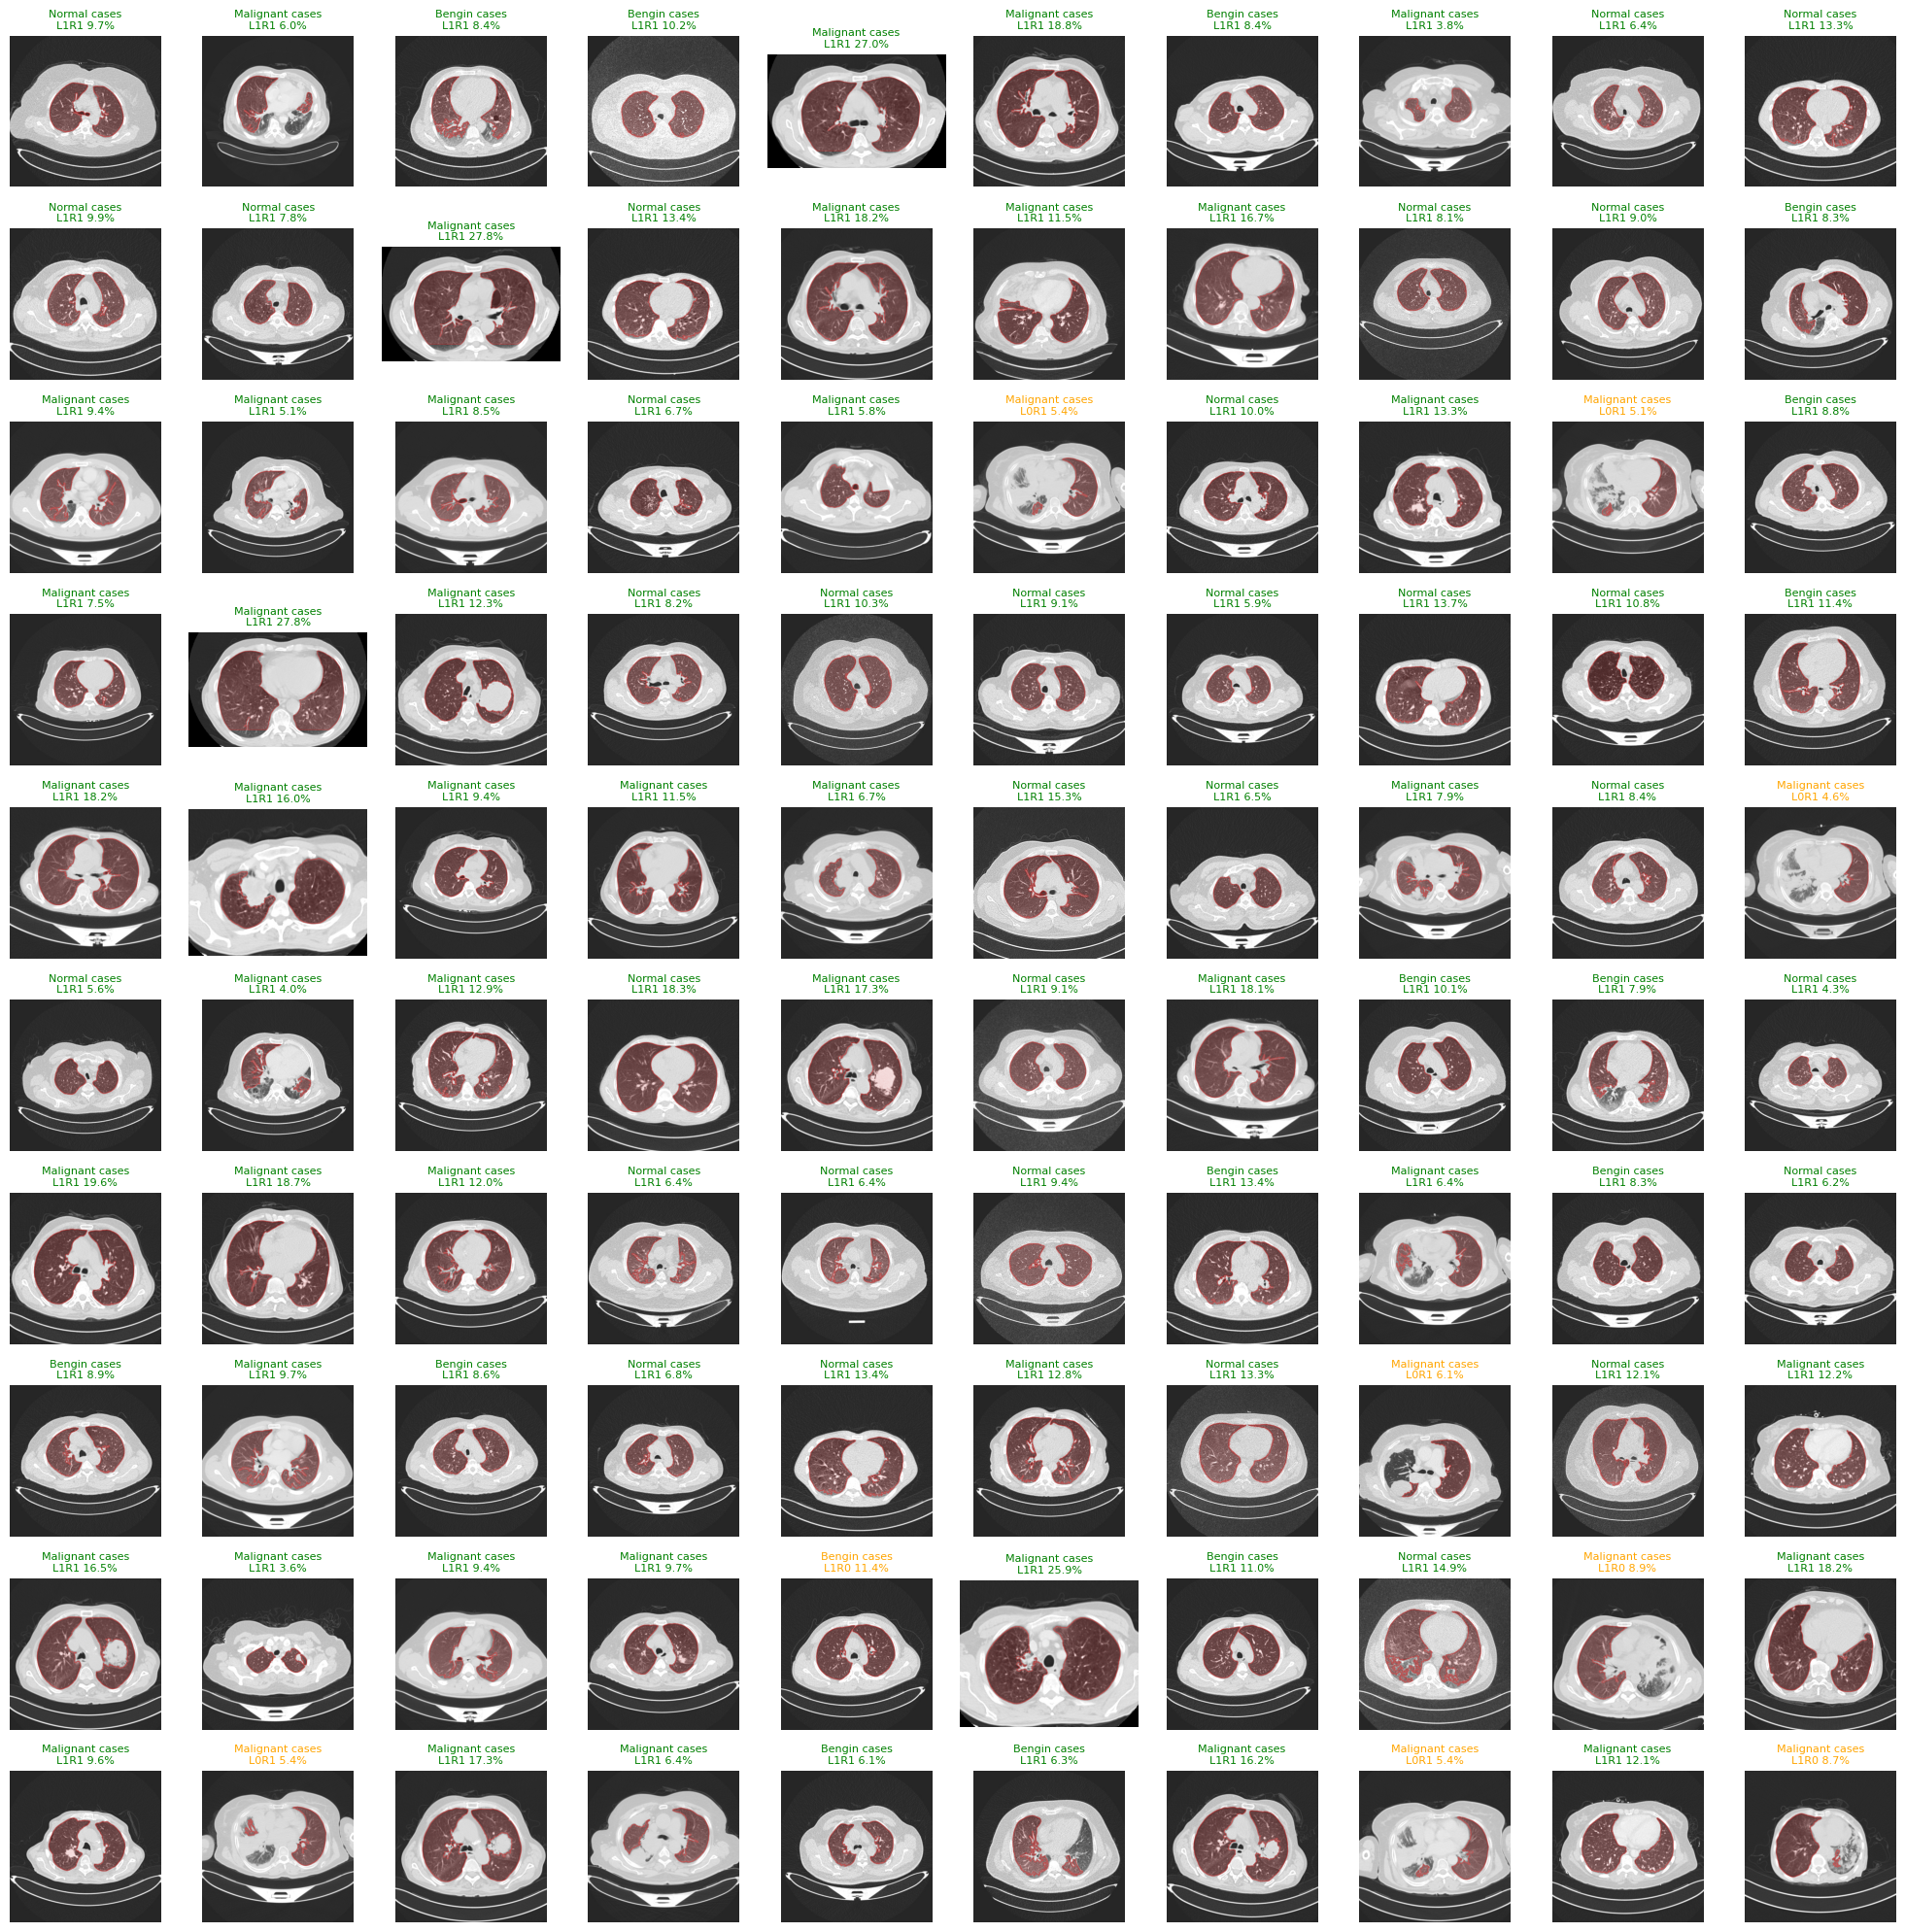


🫁 좌우 폐 검출 통계 (전체 491개):
   좌우 모두: 471개 (95.9%)
   왼쪽만: 9개 (1.8%)
   오른쪽만: 11개 (2.2%)
   검출 실패: 0개 (0.0%)


In [19]:
results = test_images(500,show_all=True)

In [21]:
save_path = save_all_preprocessed()

💾 모든 이미지 전처리 및 저장 시작...

📂 Normal cases 처리 중...
   진행: 50/416 | 성공: 49 | 실패: 1
   진행: 100/416 | 성공: 99 | 실패: 1
   진행: 150/416 | 성공: 149 | 실패: 1
   진행: 200/416 | 성공: 199 | 실패: 1
   진행: 250/416 | 성공: 248 | 실패: 2
   진행: 300/416 | 성공: 298 | 실패: 2
   진행: 350/416 | 성공: 348 | 실패: 2
   진행: 400/416 | 성공: 398 | 실패: 2
✅ Normal cases 완료: 성공 414개, 실패 2개

📂 Bengin cases 처리 중...
   진행: 50/120 | 성공: 49 | 실패: 1
   진행: 100/120 | 성공: 99 | 실패: 1
✅ Bengin cases 완료: 성공 119개, 실패 1개

📂 Malignant cases 처리 중...
   진행: 50/561 | 성공: 50 | 실패: 0
   진행: 100/561 | 성공: 100 | 실패: 0
   진행: 150/561 | 성공: 150 | 실패: 0
   진행: 200/561 | 성공: 178 | 실패: 22
   진행: 250/561 | 성공: 228 | 실패: 22
   진행: 300/561 | 성공: 278 | 실패: 22
   진행: 350/561 | 성공: 328 | 실패: 22
   진행: 400/561 | 성공: 376 | 실패: 24
   진행: 450/561 | 성공: 426 | 실패: 24
   진행: 500/561 | 성공: 476 | 실패: 24
   진행: 550/561 | 성공: 526 | 실패: 24
✅ Malignant cases 완료: 성공 537개, 실패 24개

🎉 전체 전처리 완료!
   총 성공: 1070개
   총 실패: 27개
   성공률: 97.5%
   저장 위치: .\\lung_preprocessing_results


In [23]:

def overlay_mask_on_image(lung_image, lung_mask, alpha=0.5):
    # lung_image가 grayscale이면 RGB로 변환
    if len(lung_image.shape) == 2:
        lung_image_rgb = cv2.cvtColor(lung_image, cv2.COLOR_GRAY2RGB)
    else:
        lung_image_rgb = lung_image.copy()

    # 마스크 컬러 생성 (예: 빨간색)
    mask_color = np.zeros_like(lung_image_rgb)
    mask_color[..., 0] = 255  # 빨간색

    # 마스크를 boolean으로 변환
    mask = lung_mask.astype(bool)

    # 오버레이 생성
    overlay_image = lung_image_rgb.copy()
    overlay_image[mask] = cv2.addWeighted(lung_image_rgb[mask], 1 - alpha, mask_color[mask], alpha, 0)

    return overlay_image



# 트레이닝

In [9]:
# -----------------------------------------------
# 🔧 FocusNet-LC 전체 파이프라인 (Step 1~9 통합 정리)
# -----------------------------------------------

# Step 1️⃣: 라이브러리 불러오기
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization


# Step 2️⃣: 기본 설정 (수동 zip 업로드 방식)
#from google.colab import files


# 경로 설정
#base_path = "/content/lung_preprocessing_results"
base_path = ".\\lung_preprocessing_results"
print("압축 풀린 경로 내부 폴더들:", os.listdir(base_path))

# 클래스별 이미지 개수 확인
for folder_name in ["Normal cases", "Bengin cases", "Malignant cases"]:
    full_path = os.path.join(base_path, folder_name)
    full_path = os.path.join(full_path, "processed")
    print(f"📂 {folder_name}: {full_path}")
    image_files = glob(os.path.join(full_path, "*.png"))
    print(f"📸 {folder_name}: {len(image_files)} images")

압축 풀린 경로 내부 폴더들: ['Bengin cases', 'Malignant cases', 'Normal cases']
📂 Normal cases: .\lung_preprocessing_results\Normal cases\processed
📸 Normal cases: 414 images
📂 Bengin cases: .\lung_preprocessing_results\Bengin cases\processed
📸 Bengin cases: 119 images
📂 Malignant cases: .\lung_preprocessing_results\Malignant cases\processed
📸 Malignant cases: 537 images


In [27]:
# 이미지 크기 설정
IMG_SIZE = 512

# Step 3️⃣: 폐 ROI 마스크 생성 함수 (논문 Figure 5 기반)
# 이 함수는 CT 이미지에서 폐 부위만 남기기 위한 마스크를 생성합니다.
# Threshold는 0.3 이상인 픽셀을 폐 조직으로 간주하여 선택합니다.
# 이 값은 CT 영상에서 폐가 주변보다 상대적으로 밝은 회색 계열에 위치하므로 설정됩니다.
# 이후 연결 성분 분석을 통해 작은 노이즈(blobs)를 제거합니다.
# Morphological Closing 연산을 두 번 사용해 폐 내부의 작은 구멍들을 메우고 폐 형태를 부드럽게 만듭니다.


# Step 4️⃣: 전처리1 - 이미지 증강 (좌우/상하 반전 등)
# 논문에서는 좌우반전, 상하반전과 같은 augmentation을 통해 일반화 성능을 높였다고 설명
train_datagen = ImageDataGenerator(
    horizontal_flip=True,  # 좌우반전
    vertical_flip=False,    # 상하반전
    rotation_range=10,     # 회전 증강
    zoom_range=0.2         # 확대/축소
)

# Step 5️⃣: 전처리2 - 폐 영역만 남기기 (Remove blobs → ROI 추출 → Fill holes)
def segment_lung_mask_refined(img):
    _, binary = cv2.threshold(img, 0.4, 1.0, cv2.THRESH_BINARY_INV)  # threshold ↑
    binary = binary.astype(np.uint8)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary, connectivity=8)
    sizes = stats[1:, -1]
    min_size = 1000  # 더 작은 블롭 제거
    clean_mask = np.zeros_like(binary)
    for i, size in enumerate(sizes):
        if size >= min_size:
            clean_mask[labels == i + 1] = 1
    closed = cv2.morphologyEx(clean_mask, cv2.MORPH_CLOSE, np.ones((11, 11), np.uint8))  # 커널 키움
    filled = cv2.morphologyEx(closed, cv2.MORPH_CLOSE, np.ones((15, 15), np.uint8))
    return filled


# Step 6️⃣: 전처리3 - 최종 전처리 적용 함수 (흑백화 + 정규화 + 마스크 적용)
# 두 가지 마스크 방식 비교를 위한 분기 처리 추가
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # CT는 흑백이므로 1채널로 읽기
    if img is None:
        return None
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # 논문 기준 크기 맞추기
    img = img / 255.0  # intensity scaling (논문 Block 1)

    # 선택한 방식에 따라 다른 마스크 생성 함수 적용
    #//mask = segment_lung_mask_refined(img)

    return img #* mask  # 마스크 적용하여 폐 영역만 남김

# Step 5️⃣: 데이터 로딩 함수 (이미지 + 라벨 + 메타데이터)
def load_data_with_preprocessing(preprocess_fn):
    label_dict = {'Normal cases': 0, 'Bengin cases': 1, 'Malignant cases': 2}
    images, labels, meta = [], [], []
    for label_name, label_val in label_dict.items():
        folder_path = os.path.join(base_path, label_name)
        folder_path = os.path.join(folder_path, "processed")
        image_paths = glob(os.path.join(folder_path, '*.png'))
        for path in image_paths:
            img = preprocess_fn(path)
            if img is None:
                continue
            images.append(img)
            labels.append(label_val)
            age = 0.1 #np.random.randint(50, 81) / 100
            gender = 0.1 # np.random.randint(0, 2)
            meta.append([age, gender])
    X = np.array(images).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    y = to_categorical(labels, num_classes=3)
    meta = np.array(meta)
    return X, y, meta

# Step 6️⃣: 모델 정의 함수 (FocusNet-LC)
def build_focusnetlc(input_shape=(IMG_SIZE, IMG_SIZE, 1)):
    img_input = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(img_input)
    x = Conv2D(64, (3, 3),strides=2, activation='relu', padding='same')(x)
    x = MaxPooling2D(2)(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(2)(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(2)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(1024, (3, 3), activation='relu', padding='same')(x)

    x = MaxPooling2D()(x)
    x = Flatten()(x)

    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(3, activation='softmax')(x)
    model = Model(inputs=img_input, outputs=output)
    model.compile(optimizer=Adam(0.00005), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# Step 7️⃣: Grad-CAM 히트맵 생성 함수 (수정됨)
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    preds = model.predict(img_array)
    pred_index = tf.argmax(preds[0])
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, pred_index]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Step 8️⃣: Grad-CAM 시각화 함수 (수정됨)
def show_gradcam(img, heatmap, alpha=0.6, threshold=0.4, blur_sigma=2):
    img = img[0].squeeze()
    
    # 히트맵 크기 조정
    heatmap_resized = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
    
    # 가우시안 블러로 히트맵을 부드럽게
    from scipy.ndimage import gaussian_filter
    heatmap_smooth = gaussian_filter(heatmap_resized, sigma=blur_sigma)
    
    # 임계값 적용
    heatmap_thresholded = np.where(heatmap_smooth > threshold, heatmap_smooth, 0)
    
    # 폐 영역 마스크 생성 및 부드럽게 처리
    lung_mask = img > 0.1
    lung_mask_smooth = gaussian_filter(lung_mask.astype(float), sigma=1)
    heatmap_masked = heatmap_thresholded * lung_mask_smooth
    
    # 정규화
    if heatmap_masked.max() > 0:
        heatmap_normalized = heatmap_masked / heatmap_masked.max()
    else:
        heatmap_normalized = heatmap_masked
    
    # 더 부드러운 컬러맵 적용
    heatmap_colored = plt.cm.viridis(heatmap_normalized)[..., :3]  # viridis는 더 부드러운 컬러맵
    
    # 원본 이미지 RGB 변환
    img_rgb = np.stack([img]*3, axis=-1)
    img_normalized = (img_rgb - img_rgb.min()) / (img_rgb.max() - img_rgb.min())
    
    # 부드러운 오버레이 (알파 블렌딩 개선)
    mask = heatmap_normalized > 0.01  # 더 낮은 임계값으로 부드러운 경계
    superimposed_img = img_normalized.copy()
    
    # 부드러운 알파 마스크 생성
    alpha_mask = heatmap_normalized * alpha
    alpha_mask = np.clip(alpha_mask, 0, alpha)
    
    superimposed_img[mask] = (img_normalized[mask] * (1 - alpha_mask[mask][..., np.newaxis]) + 
                             heatmap_colored[mask] * alpha_mask[mask][..., np.newaxis])
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap_normalized, cmap='viridis')
    plt.title('Smooth Heatmap')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img)
    plt.title('Smooth Grad-CAM Overlay')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [13]:
# 데이터 로드 및 분할
X, y, meta = load_data_with_preprocessing(preprocess_image)
X_train, X_temp, y_train, y_temp, meta_train, meta_temp = train_test_split(X, y, meta, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test, meta_val, meta_test = train_test_split(X_temp, y_temp, meta_temp, test_size=0.5, stratify=y_temp, random_state=42)


In [4]:
# 모델 생성
model = build_focusnetlc()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 512, 512, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 128)     147584    
                                                             

🚀 Starting training with Data Augmentation, EarlyStopping & LR Scheduler...
📊 Training samples: 749
📊 Validation samples: 160
🔄 Data augmentation: Horizontal flip, Rotation(±10°), Zoom(±10%)
📉 LR Scheduler: ReduceLROnPlateau (factor=0.5, patience=7)
Epoch 1/50
46/46 [==============================] - 21s 274ms/step - loss: 1.0109 - accuracy: 0.5075 - val_loss: 0.9316 - val_accuracy: 0.5125 - lr: 5.0000e-05
Epoch 2/50
46/46 [==============================] - 7s 142ms/step - loss: 0.9045 - accuracy: 0.5975 - val_loss: 0.8910 - val_accuracy: 0.6313 - lr: 5.0000e-05
Epoch 3/50
46/46 [==============================] - 7s 143ms/step - loss: 0.8254 - accuracy: 0.6685 - val_loss: 0.8053 - val_accuracy: 0.6687 - lr: 5.0000e-05
Epoch 4/50
46/46 [==============================] - 7s 141ms/step - loss: 0.7812 - accuracy: 0.7026 - val_loss: 0.7719 - val_accuracy: 0.6812 - lr: 5.0000e-05
Epoch 5/50
46/46 [==============================] - 7s 143ms/step - loss: 0.7628 - accuracy: 0.6862 - val_loss: 0

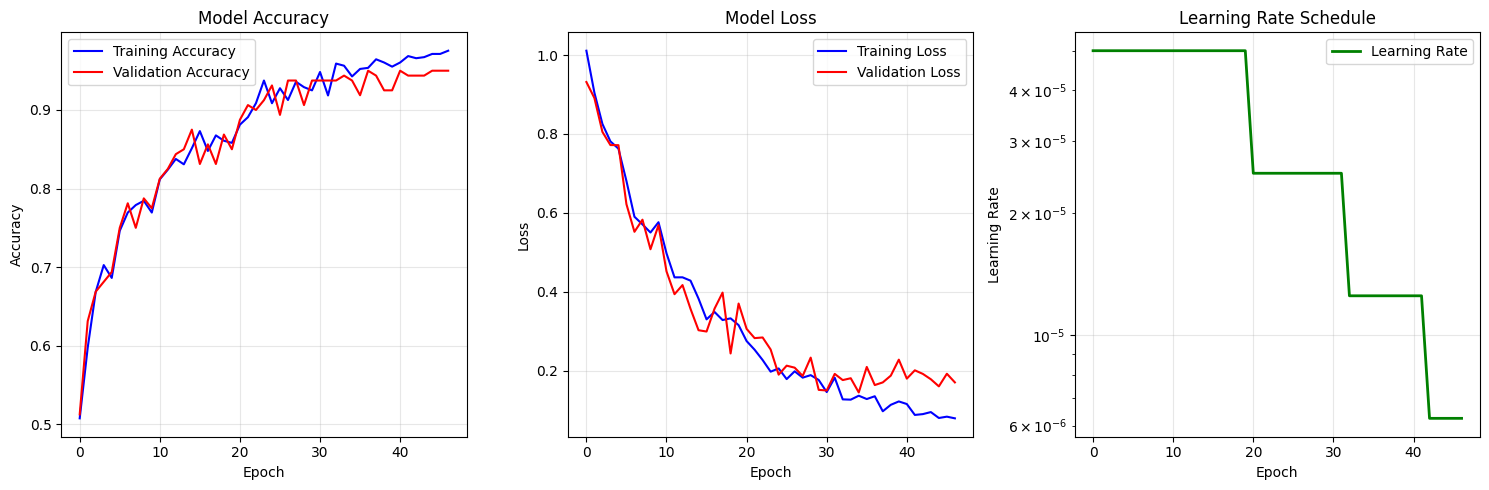


🎯 Training Enhancements:
✅ 데이터 증강으로 과적합 방지 (Data Augmentation)
✅ 조기 종료로 효율적 학습 (Early Stopping)
✅ 적응적 학습률로 최적화 개선 (Adaptive Learning Rate)
✅ 모델 robustness 및 일반화 성능 향상

📉 Learning Rate Summary:
   Initial LR: 5.00e-05
   Final LR: 6.25e-06
   LR Reduction: 8.0x


In [5]:
# Step 9️⃣: 전체 실행 (전처리 → 학습 → 평가 → Grad-CAM)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# 📌 데이터 증강 설정
train_datagen = ImageDataGenerator(
    horizontal_flip=False,   # 좌우반전
    vertical_flip=False,    # 상하반전
    rotation_range=5,      # 회전 증강
    zoom_range=0.1          # 확대/축소
)

# 검증 데이터는 증강 없이 (정규화만)
val_datagen = ImageDataGenerator()



# 📌 콜백 설정
# EarlyStopping 콜백
early_stopping = EarlyStopping(
    monitor='val_accuracy',        # 검증 정확도 모니터링
    patience=10,                   # 20 에포크 동안 개선 없으면 중단
    restore_best_weights=True,     # 최고 성능 모델로 복원
    verbose=1                      # 중단 메시지 출력
)


reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',      # 모니터할 지표
    factor=0.5,              # 학습률을 줄이는 비율 (lr * factor)
    patience=5,              # 성능이 개선되지 않아도 기다리는 epoch 수
    min_lr=1e-6,             # 최소 학습률
    verbose=1,                # 로그 출력 여부
    min_delta=1e-3,  
)

# 📌 데이터 제너레이터 생성
train_generator = train_datagen.flow(X_train, y_train, batch_size=16)
val_generator = val_datagen.flow(X_val, y_val, batch_size=16)

# 모델 학습 (데이터 증강 + EarlyStopping + LR Scheduler 적용)
print("🚀 Starting training with Data Augmentation, EarlyStopping & LR Scheduler...")
print(f"📊 Training samples: {len(X_train)}")
print(f"📊 Validation samples: {len(X_val)}")
print(f"🔄 Data augmentation: Horizontal flip, Rotation(±10°), Zoom(±10%)")
print(f"📉 LR Scheduler: ReduceLROnPlateau (factor=0.5, patience=7)")

history = model.fit(
    train_generator,                           # 📌 증강된 훈련 데이터
    validation_data=val_generator,             # 📌 검증 데이터 (증강 없음)
    epochs=50,
    steps_per_epoch=len(X_train) // 16,       # 배치 크기에 맞춘 스텝 수
    validation_steps=len(X_val) // 16,        # 검증 스텝 수
    callbacks=[early_stopping, reduce_lr], # 📌 두 콜백 모두 추가
    verbose=1
)

print(f"\n✅ Training completed!")
print(f"📈 Best validation accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"🛑 Training stopped at epoch: {len(history.history['loss'])}")

# 📌 테스트 데이터 평가
print("\n🧪 Evaluating on test data...")
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"📊 Test Accuracy: {test_accuracy:.4f}")
print(f"📊 Test Loss: {test_loss:.4f}")

# 📌 학습 곡선 시각화 (Learning Rate 추가)
plt.figure(figsize=(15, 5))

# 정확도 곡선
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# 손실 곡선
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# 📌 Learning Rate 변화 곡선
plt.subplot(1, 3, 3)
plt.plot(history.history['lr'], label='Learning Rate', color='green', linewidth=2)
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.yscale('log')  # 로그 스케일로 표시
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🎯 Training Enhancements:")
print("✅ 데이터 증강으로 과적합 방지 (Data Augmentation)")
print("✅ 조기 종료로 효율적 학습 (Early Stopping)")
print("✅ 적응적 학습률로 최적화 개선 (Adaptive Learning Rate)")
print("✅ 모델 robustness 및 일반화 성능 향상")

# 📌 학습률 변화 요약 출력
if 'lr' in history.history:
    initial_lr = history.history['lr'][0]
    final_lr = history.history['lr'][-1]
    print(f"\n📉 Learning Rate Summary:")
    print(f"   Initial LR: {initial_lr:.2e}")
    print(f"   Final LR: {final_lr:.2e}")
    print(f"   LR Reduction: {initial_lr/final_lr:.1f}x")

In [3]:
# 모델 저장

In [23]:
 model.save("lung_model.h5")

In [ ]:
#모델 불러기기

In [5]:
from tensorflow.keras.models import load_model

# 저장된 모델 로드
model = load_model("lung_model.h5")

# 모델 구조 확인
model.summary()


print(f"모델 입력 형태: {model.input_shape}")
print(f"모델 출력 형태: {model.output_shape}")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 512, 512, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 128)     147584    
                                                             

In [23]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print("\n✅ Test Accuracy:", round(acc * 100, 2), "%")

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)
print("\n🧾 Classification Report:")
print(classification_report(y_true, y_pred))
print("\n📊 Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))




✅ Test Accuracy: 95.03 %
6/6 [==============================] - 1s 99ms/step

🧾 Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95        62
           1       0.78      0.78      0.78        18
           2       1.00      0.98      0.99        81

    accuracy                           0.95       161
   macro avg       0.91      0.91      0.91       161
weighted avg       0.95      0.95      0.95       161


📊 Confusion Matrix:
[[60  2  0]
 [ 4 14  0]
 [ 0  2 79]]


1/1 [==============================] - 0s 17ms/step


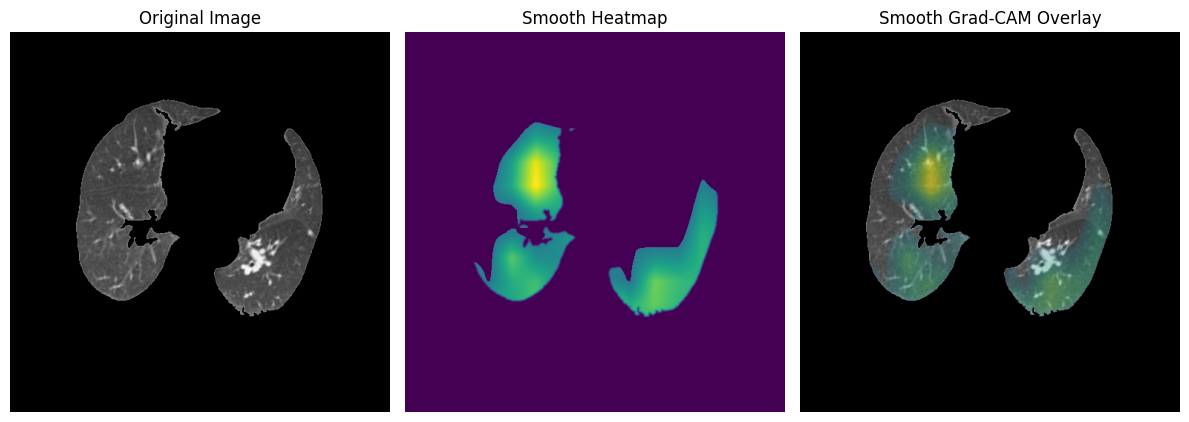

1/1 [==============================] - 0s 19ms/step


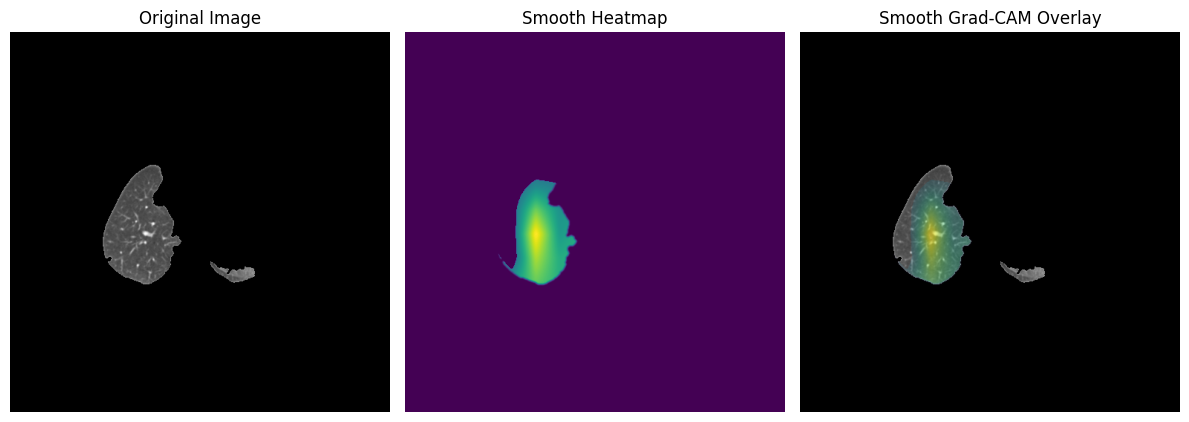

In [29]:
x_g = X_test[2:3]
last_conv_layer = [layer.name for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)][-1]

heatmap = make_gradcam_heatmap(x_g, model, last_conv_layer)
show_gradcam(x_g, heatmap)

heatmap = make_gradcam_heatmap(X_test[10:11], model, last_conv_layer)
show_gradcam(X_test[10:11], heatmap)